# Making inference with pretrained UNet and B-UNet models

Define functions and set up environment

In [11]:
import torch
import sys
sys.path.append("/media/hdd/viscent/SR-UNet")
from models.unet3d.model import BUNet3D,UNet3D

import os 
import numpy as np
import SimpleITK as sitk
import ants
%matplotlib inline
import matplotlib.pyplot as plt
import torch.nn as nn
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torchviz import make_dot
from colossalai.utils import load_checkpoint
from colossalai.initialize import launch,initialize
import colossalai
from colossalai.trainer import Trainer, hooks
import h5py as h5
from dataloaders import get_synth_dhcp_dataloader, get_synth_hcp_dataloader
import torchio as tio
import pandas as pd

from ipywidgets import interact, fixed
from IPython.display import clear_output

In [19]:
# Callback invoked by the IPython interact method for scrolling and modifying the alpha blending
# of an image stack of two images that occupy the same physical space.
def display_image(image_z, image):
    img = image[:, :, image_z]
    plt.imshow(sitk.GetArrayViewFromImage(img), cmap=plt.cm.Greys_r)
    plt.axis("off")
    plt.show()

def load_model(model_path:str):
    model = torch.load(model_path)
    model.train()
    return model

def get_dataloader(dataset = 'dhcp', batch_size = 1, data_dir = '/home/viscent/hdd/dhcp/dhcp_lores/'):
    if dataset == 'dhcp':
        dataloaders, val_loader = get_synth_dhcp_dataloader(data_dir=data_dir,
                                                            batch_size=batch_size,
                                                            num_samples=None,
                                                            input_modalities=["t1"],
                                                            output_modalities=["t1"],
                                                            output_dir=data_dir,
                                                            n_splits=5,
                                                            augmentation=False,
                                                            down_factor=5,)
    elif dataset == 'hcp':
        dataloaders, val_loader = get_synth_hcp_dataloader(data_dir=data_dir,
                                                            batch_size=batch_size,
                                                            num_samples=None,
                                                            input_modalities=["t1"],
                                                            output_modalities=["t1"],
                                                            output_dir=data_dir,
                                                            n_splits=5,
                                                            augmentation=False,
                                                            down_factor=5,)
    return val_loader

def load_image(mode :str = 'h5', 
               paths = ['/home/viscent/hdd/dhcp/dhcp_lores/preprocessed_h5/sub-CC00582XX14.h5'],
               dataset = 'dhcp',
               data_dir = '/home/viscent/hdd/dhcp/dhcp_lores/',):
    if mode == 'h5':
        with h5.File(paths[0],'r') as f:
            image = f['image_t1'][...].astype(np.float32)
            target = f['gt_t1'][...].astype(np.float32)
        image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).cuda()
        target_tensor = torch.from_numpy(target).unsqueeze(0).unsqueeze(0).cuda()
        return image_tensor,target_tensor
    elif mode == 'sitk':
        image = sitk.ReadImage(paths[0])
        target = sitk.ReadImage(paths[1])
        image = sitk.GetArrayFromImage(image)
        target = sitk.GetArrayFromImage(target)
        image_tensor = torch.from_numpy(image).unsqueeze(0).unsqueeze(0).cuda()
        target_tensor = torch.from_numpy(target).unsqueeze(0).unsqueeze(0).cuda()
        return image_tensor,target_tensor
    elif mode == 'npy':
        image = np.load(paths[0])
        target = np.load(paths[1])
        image_tensor = torch.from_numpy(image).unsqueeze(0).cuda()
        target_tensor = torch.from_numpy(target).unsqueeze(0).cuda()
        return image_tensor,target_tensor
    elif mode == 'dataloader':
        if dataset == 'dhcp':
            dataloaders, val_loader = get_synth_dhcp_dataloader(data_dir=data_dir,
                                                                batch_size=1,
                                                                num_samples=50,
                                                                input_modalities=["t1"],
                                                                output_modalities=["t1"],
                                                                output_dir=data_dir,
                                                                n_splits=5,
                                                                augmentation=False,
                                                                down_factor=5,)
        elif dataset == 'hcp':
            dataloaders, val_loader = get_synth_hcp_dataloader(data_dir=data_dir,
                                                                batch_size=1,
                                                                num_samples=50,
                                                                input_modalities=["t1"],
                                                                output_modalities=["t1"],
                                                                output_dir=data_dir,
                                                                n_splits=5,
                                                                augmentation=False,
                                                                down_factor=5,)
        image_tensor, target_tensor = next(iter(val_loader))
        image_tensor = image_tensor.cuda()
        target_tensor = target_tensor.cuda()
        return image_tensor,target_tensor

def plot_latent(model):
    encoder_weights = next(model.encoders[-1].parameters())
    encoder_weights = encoder_weights.cpu().detach().numpy()
    encoder_weights= np.expand_dims(encoder_weights,axis=1)
    encoder_weights = np.repeat(encoder_weights, 128, axis=1)
    if hasattr(model, 'enc_mu'):
        fig,(ax1,ax2) = plt.subplots(1,2)
        im1 = ax1.imshow(encoder_weights)
        ax1.set_title("encoder weights")
        divider = make_axes_locatable(ax1)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im1, cax=cax, orientation="vertical")

        latent_weights = next(model.mu.parameters())
        latent_weights = latent_weights.cpu().detach().numpy()
        latent_weights = np.repeat(latent_weights, 128, axis=1)

        im2 = ax2.imshow(encoder_weights)
        ax2.set_title("latent weights")
        divider = make_axes_locatable(ax2)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(im2, cax=cax, orientation="vertical")
        fig.show()
    else:
        fig = plt.imshow(encoder_weights)
        plt.title("encoder weights")
        plt.colorbar()
        plt.show()
    # plt.savefig(OUTPUT_PREFIX+"_encoder_weights.png")

def infer(model,image_tensor):
    output_tensor = model(image_tensor)
    return output_tensor

def get_metrics(output_tensor,target_tensor, model, mu_q = None, logvar_q = None):
    im = target_tensor
    im_hat = output_tensor
    mse = torch.nn.MSELoss()(im, im_hat)
    mse.backward()
    print('mse:', mse.cpu().detach().numpy())
    if hasattr(model, 'enc_mu'):
        mu_p, logvar_p = model.enc_mu,model.enc_logvar
        # kl = (0.5 * ((torch.ones_like(logvar_p)-torch.ones_like(logvar_p)) + (mu_p-mu_q)**2 / torch.ones_like(logvar_p).exp() - 1 + (torch.ones_like(logvar_p)).exp() / (torch.ones_like(logvar_p)).exp() )).sum()
        # kl = (0.5 * ((logvar_q-logvar_p) + (mu_p-mu_q)**2 / logvar_q.exp() - 1 + logvar_p.exp() / logvar_q.exp())).mean()
        kl = 0.5 * (logvar_p.exp() + mu_p**2 - 1 - logvar_p).sum()
        # kl = 0.5 * ((logvar_q-logvar_p) - 3 + (mu_p - mu_q) / logvar_q.exp() * (mu_p-mu_q) + torch.trace)
        # kl = torch.sum(kl)
        FE_simple = mse + 0.00025 * kl
        print('kl:', kl.cpu().detach().numpy())
        print('Free energy:', FE_simple.cpu().detach().numpy())

def plot_output(image_tensor,output_tensor,target_tensor):
    image_tensor = image_tensor.cpu().squeeze().squeeze().detach().numpy().astype(np.float32)
    output_tensor = output_tensor.cpu().squeeze().squeeze().detach().numpy().astype(np.float32)
    target_tensor = target_tensor.cpu().squeeze().squeeze().detach().numpy().astype(np.float32)
    fig,(ax1,ax2,ax3) = plt.subplots(1,3)
    im1 = ax1.imshow(image_tensor[image_tensor.shape[0]//2,:,:],cmap='gray')
    ax1.set_title("image")


    im2 = ax2.imshow(output_tensor[output_tensor.shape[0]//2,:,:],cmap='gray')
    ax2.set_title("output")
    
    
    im3 = ax3.imshow(target_tensor[target_tensor.shape[0]//2,:,:],cmap='gray')
    ax3.set_title("target")
    fig.show()
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the
# metric_values list.
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))
    
def registration_sitk(fixed_image, moving_image):
    initial_transform = sitk.CenteredTransformInitializer(
        fixed_image,
        moving_image,
        sitk.Euler3DTransform(),
        sitk.CenteredTransformInitializerFilter.GEOMETRY,
    )

    moving_resampled = sitk.Resample(
        moving_image,
        fixed_image,
        initial_transform,
        sitk.sitkLinear,
        0.0,
        moving_image.GetPixelID(),
    )
    registration_method = sitk.ImageRegistrationMethod()

    # Similarity metric settings.
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetMetricSamplingPercentage(0.01)

    registration_method.SetInterpolator(sitk.sitkLinear)

    # Optimizer settings.
    registration_method.SetOptimizerAsGradientDescent(
        learningRate=1.0,
        numberOfIterations=100,
        convergenceMinimumValue=1e-6,
        convergenceWindowSize=10,
    )
    registration_method.SetOptimizerScalesFromPhysicalShift()

    # Setup for the multi-resolution framework.
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[4, 2, 1])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[2, 1, 0])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    # Don't optimize in-place, we would possibly like to run this cell multiple times.
    registration_method.SetInitialTransform(initial_transform, inPlace=False)


    final_transform = registration_method.Execute(
        sitk.Cast(fixed_image, sitk.sitkFloat32), sitk.Cast(moving_image, sitk.sitkFloat32)
    )
    moving_resampled = sitk.Resample(
        moving_image,
        fixed_image,
        final_transform,
        sitk.sitkLinear,
        0.0,
        moving_image.GetPixelID(),
    )
    return moving_resampled

def resample(image):
    target_shape = (108, 145, 145)
    spacing = [1.0,1.0,1.0]
    spacing = np.array(spacing)
    resample_transform = tio.Resample(target=spacing)
    resize_transform = tio.Resize(target_shape=target_shape)
    transform  = tio.Compose([resample_transform,resize_transform])
    return transform(image)

def _downSample(image, factor_ds, factor_blur):
    spacing = [1.0,1.0,1.0]
    spacing = np.array(spacing)
    spacing *= factor_ds
    target_shape = (108, 145, 145)
    factor = spacing[2] / spacing[0]
    resize_transform = tio.Resize(target_shape=target_shape)
    resample_transform = tio.Resample(target=spacing)
    blur_transform = tio.RandomBlur(factor_blur)
    transform  = tio.Compose([resample_transform,resize_transform,blur_transform])
    return transform(image)

def downSample(image):
    return downSample(image, factor_ds=5, factor_blur=3)


def registration_ants(fixed_image, moving_image):
    fixed_array = sitk.GetArrayFromImage(fixed_image)
    moving_array = sitk.GetArrayFromImage(moving_image)
    fixed_ants = ants.from_numpy(fixed_array)
    moving_ants = ants.from_numpy(moving_array)
    ret = ants.registration(fixed_ants, moving_ants,verbose=True)
    image = ret['warpedmovout'].numpy()
    image = sitk.GetImageFromArray(image)
    image.CopyInformation(fixed_image)
    return image

In [3]:
model_vae_dhcp = load_model('/media/hdd/viscent/create-models/20220609/vae_dhcp/499.pth')
model_vae_hcp = load_model('/media/hdd/viscent/create-models/20220609/vae_hcp/499.pth')
model_unet_dhcp = load_model('/media/hdd/viscent/create-models/20220607/unet_dhcp/299.pth')
model_unet_hcp = load_model('/media/hdd/viscent/create-models/20220607/unet_hcp/299.pth')

mu_vae_dhcp = model_vae_dhcp.enc_mu
logvar_vae_dhcp = model_vae_dhcp.enc_logvar
mu_vae_hcp = model_vae_hcp.enc_mu
logvar_vae_hcp = model_vae_hcp.enc_logvar

In [6]:
dataloader = get_dataloader()

[07/04/22 16:57:58] INFO     colossalai - root - INFO: Creating dataset with 510 examples

                    INFO     colossalai - root - INFO: length of list_images_t1: 510

  0%|          | 0/510 [00:00<?, ?it/s]

[07/04/22 16:59:22] INFO     colossalai - root - INFO: Creating dataset with 127 examples

                    INFO     colossalai - root - INFO: length of list_images_t1: 128

  0%|          | 0/127 [00:00<?, ?it/s]

In [63]:
mse_df = pd.DataFrame(columns=['mse','downsample_factor','blur_factor'])
ds_array = np.arange(1,10)
blur_array = np.arange(1,10)

In [ ]:

from tqdm import trange,tqdm


for i in trange(20):
    image_tensor, target_tensor = next(iter(dataloader))
    image = sitk.GetImageFromArray(image_tensor[0,0].numpy())
    for ds in ds_array:
        for blur in blur_array:
            print('ds:',ds,'blur:',blur)
            image_tmp = _downSample(image,ds,blur)
            image_tmp = sitk.GetArrayFromImage(image_tmp)
            image_tensor = torch.from_numpy(image_tmp).unsqueeze(0).unsqueeze(0).float().cuda()
            output = model_vae_dhcp(image_tensor)
            mse = torch.nn.MSELoss()(target_tensor.cuda(), output)
            metrics = dict(mse=mse.item(),downsample_factor=ds,blur_factor=blur)
            mse_df.loc[len(mse_df)] = metrics
            
            

In [66]:
mse_df

,mse,downsample_factor,blur_factor
0,0.074870,1,1
1,0.074747,1,2
2,0.075394,1,3
3,0.075859,1,4
4,0.076887,1,5
...,...,...,...
1615,0.245100,9,5
1616,0.239166,9,6
1617,0.253284,9,7
1618,0.241018,9,8


array([[<AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>,
        <AxesSubplot:title={'center':'3'}>],
       [<AxesSubplot:title={'center':'4'}>,
        <AxesSubplot:title={'center':'5'}>,
        <AxesSubplot:title={'center':'6'}>],
       [<AxesSubplot:title={'center':'7'}>,
        <AxesSubplot:title={'center':'8'}>,
        <AxesSubplot:title={'center':'9'}>]], dtype=object)

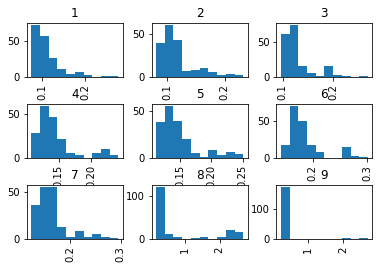

In [70]:
mse_df.hist(column='mse',by='downsample_factor')

In [111]:
hist_mat = np.zeros((9,9))
for item in mse_df.itertuples():
    mse = min(item.mse,0.3)
    hist_mat[item.downsample_factor-1,item.blur_factor-1] += mse
    hist_mat[item.downsample_factor-1,item.blur_factor-1] /= 2

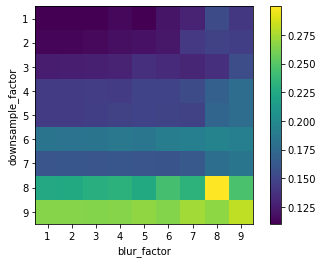

In [115]:
plt.imshow(hist_mat)
plt.xlabel('blur_factor')
plt.xticks(np.arange(9),blur_array)
plt.ylabel('downsample_factor')
plt.yticks(np.arange(9),ds_array)
plt.colorbar()